This notebook is to understand INN framework by applying it to different examples 

Importing modules

In [2]:
# Libraries
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mc
import colorsys
# Pytorch
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
#from torchviz import make_dot # for visualizing the architecture as a graph

# FrEIA imports
from FrEIA.framework import InputNode,OutputNode, Node, ReversibleGraphNet,ConditionNode
from FrEIA.modules import GLOWCouplingBlock,PermuteRandom,RNVPCouplingBlock

# cuda
from torch.cuda.amp import GradScaler, autocast

# inverse kinematics
%run FABRIK_method_copy.ipynb

Setting up

In [3]:
# Config 
parameters={'l':2.0}
num_examples=30
reps=10000
num_samples=reps*num_examples
num_inputs=4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

TEST_TRAIN_SPLIT=0.8
BATCH_SIZE=1000

current_lr=1e-3
num_epochs=35
mix_precision = False

# These are not yet being utilized.
mmd_forw_kernels = [(0.2, 2), (1.5, 2), (3.0, 2)]
mmd_back_kernels = [(0.2, 0.1), (0.2, 0.5), (0.2, 2)]

width_exponents=[0.05,0.2,0.9]

Defining MMD

In [4]:
def MMD_matrix_multiscale(x, y, widths_exponents,device):
    xx, yy, xy = torch.mm(x,x.t()), torch.mm(y,y.t()), torch.mm(x,y.t())

    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))

    dxx = torch.clamp(rx.t() + rx - 2.*xx, 0, np.inf)
    dyy = torch.clamp(ry.t() + ry - 2.*yy, 0, np.inf)
    dxy = torch.clamp(rx.t() + ry - 2.*xy, 0, np.inf)

    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))

    for C,a in widths_exponents:
        XX += C**a * ((C + dxx) / a)**-a
        YY += C**a * ((C + dyy) / a)**-a
        XY += C**a * ((C + dxy) / a)**-a
    return torch.mean(XX + YY - 2.*XY)


In [5]:
# Move parameters to the CPU
for key, value in parameters.items():
    if isinstance(value, torch.Tensor):
        parameters[key] = value.to(device)


Defining the local INN architecture

In [8]:
# Defining the affine coupling blocks with conditional input
class loc_INN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device=device
        self.num_blocks=6
        self.inn=self.inn_model()
        # self.cond_net=self.subnet_cond(COND_OUT)

        self.trainable_params=[p for p in self.inn.parameters() if p.requires_grad]
        # print(self.trainable_params)
        if not self.trainable_params:
            print("No trainable paramters found..--> Exiting")
            raise SystemExit
        for param in self.trainable_params:
            param.data = 0.05 * torch.randn_like(param)

    def inn_model(self):
        
        def subnet_fc(cin,cout):
            return nn.Sequential(nn.Linear(cin,12),nn.ReLU(),nn.Linear(12,cout))

        nodes=[InputNode(int(num_inputs),name='input')]
        
        for k in range(self.num_blocks):
            nodes.append(Node(nodes[-1],GLOWCouplingBlock,{'subnet_constructor': subnet_fc,'clamp':2.0},conditions=None,name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],PermuteRandom,{'seed':k},name=F'permute_{k}'))

        nodes.append(OutputNode(nodes[-1],name='output'))
        return ReversibleGraphNet(nodes , verbose=False).to(self.device)

    def forward(self, x):
        return self.inn(x)
    
    def reverse(self, y_rev):
        return self.inn(y_rev, rev=True)

device="cpu"
loc_inn=loc_INN(device=device)# Move the entire model to device

loc_inn=loc_inn.to(torch.float32) # Convert the entire model into double

print(loc_inn)

loc_INN(
  (inn): ReversibleGraphNet(
    (module_list): ModuleList(
      (0): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
        (subnet2): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
      )
      (1): PermuteRandom()
      (2): GLOWCouplingBlock(
        (subnet1): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
        (subnet2): Sequential(
          (0): Linear(in_features=2, out_features=12, bias=True)
          (1): ReLU()
          (2): Linear(in_features=12, out_features=4, bias=True)
        )
      )
      (3): PermuteRandom()
      (4): GLOWCouplingBlock(

Setting up functions for the neural network.

In [ ]:
loc_inn=loc_INN(device)
loc_inn=loc_inn.to(torch.float32)
loc_inn=loc_inn.to(device)

# Loss 
MSE_loss=torch.nn.MSELoss().to(device) 
l1_loss=torch.nn.L1Loss().to(device)

# Instantiating the optimizers and adding the parameters
optimizer = torch.optim.Adam(loc_inn.trainable_params, lr=current_lr)
scaler=GradScaler(enabled=mix_precision)
scheduler=ExponentialLR(optimizer,gamma=0.95)

Setting up functions to find the positions of each joint from the angles.

In [7]:
def positions(phi,l=parameters["l"]):
    """
    Find the coordinates of the joints of a 4R manipulator given the angles and the length of the links
    
    phi = array of angles 
    l = the length of the links considering all links are of the same length
    """
    x,y=np.zeros((5,1)),np.zeros((5,1))
    x[1,:],y[1,:]=x[0,:]+l*np.cos(phi[0]),y[0,:]+l*np.sin(phi[0])
    x[2,:],y[2,:]=x[1,:]+l*np.cos(phi[1]),y[1,:]+l*np.sin(phi[1])
    x[3,:],y[3,:]=x[2,:]+l*np.cos(phi[2]),y[2,:]+l*np.sin(phi[2])
    x[4,:],y[4,:]=x[3,:]+l*np.cos(phi[3]),y[3,:]+l*np.sin(phi[3])
    
    return np.concatenate((x,y),axis=1)

def posn(phi,l=parameters["l"]):
    """
    Find the coordinates of the joints of a 4R manipulator given the angles and the length of the links
    
    phi = array of angles 
    l = the length of the links considering all links are of the same length
    """
    x,y=np.zeros((5,)),np.zeros((5,))
    x[1],y[1]=x[0]+l*np.cos(phi[0]),y[0]+l*np.sin(phi[0])
    x[2],y[2]=x[1]+l*np.cos(phi[1]),y[1]+l*np.sin(phi[1])
    x[3],y[3]=x[2]+l*np.cos(phi[2]),y[2]+l*np.sin(phi[2])
    x[4],y[4]=x[3]+l*np.cos(phi[3]),y[3]+l*np.sin(phi[3])
    return x,y


Visualising the data points.

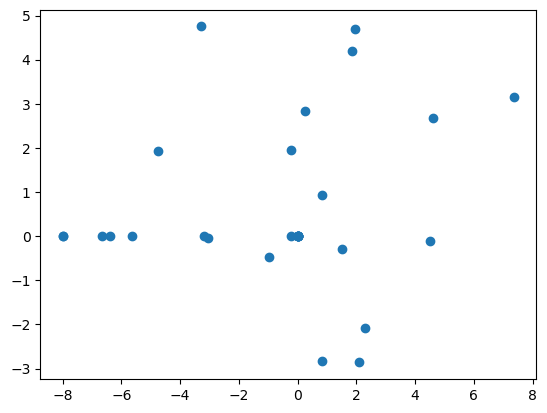

In [8]:

p=np.zeros((5,2))
# Generating end effector examples
beta=np.random.randn(num_examples,1)
radius=np.random.randn(num_examples,1)
beta=np.clip(a=beta,a_min=-1,a_max=1,out=beta)
radius=np.clip(a=radius,a_min=-1,a_max=1,out=radius)
beta=np.pi*beta
radius=4+4*radius

end_eff=np.zeros((num_examples,2))
for j in range(0, num_examples):
    arr_rep=np.array([radius[j,0]*np.cos(beta[j,0]),radius[j,0]*np.sin(beta[j,0])])
    end_eff[j,:]=arr_rep

plt.figure()
plt.scatter(end_eff[:,0],end_eff[:,1])
# print(end_eff[0,:])
# Setting up thetas for intial configurations
ini_thetas=np.random.randn(reps,4)

# x_dash=np.zeros((5,))
# y_dash=np.zeros((5,))


Finding out the angles from the given end effector positions

In [9]:

# Finding the angles and then appending them to the target point

values_inv=np.zeros((1,6))

for example in range(0,num_examples):
    for i in range(0,ini_thetas.shape[0]):
        p_initial=positions(ini_thetas[i,:])
        angles,points=FABRIK_solver(aim=end_eff[example,:],p=p_initial)
        target=end_eff[example,:].reshape((1,2))
        solution_set=np.concatenate((angles,target),axis=1)
        values_inv=np.concatenate((values_inv,solution_set),axis=0)
values_inv=np.delete(values_inv,0,axis=0)

values_inv = np.unique(values_inv,axis=0)
print(values_inv.shape)



# %matplotlib qt
# plt.figure(figsize=(20,20))
# for j in range(0,num_examples):
#     plt.subplot(5,2,j+1)
#     flag=True
#     for val in range(j*reps,(j+1)*reps):
#         point = positions(values_inv[val,:4])
#         if flag==True:
#             plt.plot(point[:,0],point[:,1],linewidth="0.5",marker="^",label="Configuration")
#             plt.plot(0,0,"k",marker="o",label="Starting Point")
#             plt.plot(point[4,0],point[4,1],"r",marker="o",label="Target point")
#             flag=False
            
#         else:
#             plt.plot(point[:,0],point[:,1],linewidth="0.5",marker="^")
#             plt.plot(0,0,"k",marker="o")
#             plt.plot(point[4,0],point[4,1],"r",marker="o")
#         plt.grid()
        
#         plt.title(f"Configurations for example number {j+1}")
#     plt.legend()
# plt.suptitle('Inverse Kinematics Configurations')
# plt.tight_layout()
# plt.show()
        
# plt.legend()
# plt.grid()
# plt.show()




(240000, 6)


Loading data into csv file

In [10]:

p_x,p_y=np.zeros((5,values_inv.shape[0])),np.zeros((5,values_inv.shape[0]))


for val in range(0,values_inv.shape[0]):
    p_x[:,val],p_y[:,val] = posn(values_inv[val,:4])

inv_data = {'theta1':values_inv[:,0],'theta2':values_inv[:,1],'theta3':values_inv[:,2],'theta4':values_inv[:,3],
         'end_x':values_inv[:,4],'end_y':values_inv[:,5],
         'x1':p_x[1,:],'x2':p_x[2,:],'x3':p_x[3,:],'x4':p_x[4,:],
         'y1':p_y[1,:],'y2':p_y[2,:],'y3':p_y[3,:],'y4':p_y[4,:]}

df_data=pd.DataFrame(inv_data)
# print(df_data)
df_data.to_csv('INN_IK_inv_data.csv',index=False)

data_ik=(pd.read_csv('INN_IK_inv_data.csv')).values
print(type(data_ik))

np.random.seed(1)
data_ik=np.random.permutation(data_ik)

data_tens=torch.from_numpy(data_ik)
data_tens=data_tens.to(torch.float32)
data_tens=data_tens.to(device)
print(data_ik.shape)

ind_split = int(TEST_TRAIN_SPLIT*num_samples)

# Splitting the data into batches
data_train = data_tens[:ind_split,:]
data_test = data_tens[ind_split:,:]

print(data_test.dtype)
# data_train_ten, data_test_ten = torch.from_numpy(data_train), torch.from_numpy(data_test)


df_test = pd.DataFrame(data_test)
df_test.to_csv("testing_dataset.csv",index=False)
df_train = pd.DataFrame(data_train)
df_train.to_csv("training_dataset.csv", index=False)

train_dataset, test_dataset = data_train.to(torch.float32), data_test.to(torch.float32)
train_dataset, test_dataset= train_dataset.to(device), test_dataset.to(device)

# Dividing the data into minibatches
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,batch_size=BATCH_SIZE,shuffle=True,drop_last=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset,batch_size=BATCH_SIZE,shuffle=False,drop_last=True)

<class 'numpy.ndarray'>
(240000, 14)
torch.float32


Bidirectional Training

In [11]:
loc_inn.train()
forward_loss=[]
reverse_loss=[]
z_loss_store=[]
for epoch in range(num_epochs):
    for batch_idx, data_x in enumerate(train_loader):
        optimizer.zero_grad()
        with autocast(enabled=mix_precision):
            x_train=data_x[:,:4]
    #         print(x_train.shape)
            y_pred,para=loc_inn.forward(x_train)
    #         print(type(y_pred))
            y_gt=data_x[:,4:6]
            z_sample=torch.randn((x_train.shape[0],2)).to(torch.float32)
            z_sample=z_sample.to(device)
            
            # Forward losses 
            inn_recon_loss=MSE_loss(y_pred[:,:2],y_gt)
            z_loss=MMD_matrix_multiscale(y_pred[:,2:4],z_sample,mmd_forw_kernels,device)
            
            tot_forward_loss=inn_recon_loss+z_loss
        scaler.scale(tot_forward_loss).backward(retain_graph=True)
        
        with autocast(enabled=mix_precision):
            y_train=data_x[:,4:6]
            
            samples=torch.randn((y_train.shape[0],2)).to(device)
            y_rev=torch.cat((y_train,samples),1)
            y_rev2=torch.cat((y_train,y_pred[:,2:4]),1)
            x_pred,_=loc_inn.reverse(y_rev)
            x_pred2,_=loc_inn.reverse(y_rev2)
            loss_rev_origin_z=MMD_matrix_multiscale(x_pred,x_train,mmd_back_kernels,device)
            tot_backward_loss=MSE_loss(x_pred2,x_train)+loss_rev_origin_z
        scaler.scale(tot_backward_loss).backward()
        scaler.unscale_(optimizer)
        
        scaler.step(optimizer)
        
        scaler.update()
    z_loss_store.append(z_loss.item())
    forward_loss.append(tot_forward_loss.item())
    reverse_loss.append(tot_backward_loss.item())
    print(f"Epoch [{epoch+1}/{num_epochs}], FLoss:{tot_forward_loss.item()}, RLoss:{tot_backward_loss.item()}, BLoss orig:{loss_rev_origin_z.item()}")

print(y_pred[4,:], "Predicted")
print(y_rev[4,:], "True end eff, sampling done")
print(y_pred.shape)
print(y_rev.shape)

Epoch [1/35], FLoss:3.3681037425994873, RLoss:1.278282880783081, BLoss orig:0.059170350432395935
Epoch [2/35], FLoss:1.0742285251617432, RLoss:0.48083963990211487, BLoss orig:0.058086663484573364
Epoch [3/35], FLoss:0.7753080725669861, RLoss:0.36023393273353577, BLoss orig:0.062103740870952606
Epoch [4/35], FLoss:0.5730035305023193, RLoss:0.2790486812591553, BLoss orig:0.04938825964927673
Epoch [5/35], FLoss:0.507721483707428, RLoss:0.2473459541797638, BLoss orig:0.051054079085588455
Epoch [6/35], FLoss:0.4970781207084656, RLoss:0.2378183901309967, BLoss orig:0.04683243855834007
Epoch [7/35], FLoss:0.46824103593826294, RLoss:0.22505174577236176, BLoss orig:0.05123715475201607
Epoch [8/35], FLoss:0.40007659792900085, RLoss:0.18359215557575226, BLoss orig:0.04826163128018379
Epoch [9/35], FLoss:0.3708726763725281, RLoss:0.16703669726848602, BLoss orig:0.04599112644791603
Epoch [10/35], FLoss:0.3632785975933075, RLoss:0.16827166080474854, BLoss orig:0.04535301402211189
Epoch [11/35], FLos

Plotting the errors

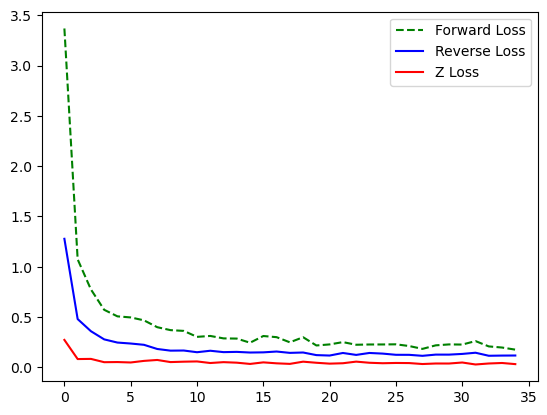

In [12]:
plt.figure()
plt.plot(forward_loss,'--g',label='Forward Loss')
plt.plot(reverse_loss,"-b",label="Reverse Loss")
plt.plot(z_loss_store,'-r',label="Z Loss")
plt.legend()
plt.show()

Testing

In [19]:
loc_inn.eval()
ran_int = 134678
# print(data_x.shape)
for_loss=[]
rev_loss=[]
x_pred_store=[]
y_pred_store=[]
angle_values=np.zeros((reps,4))
with torch.no_grad():
    with autocast(enabled=mix_precision):
        x_test=data_train[ran_int,0:4]
        x_test=x_test.unsqueeze(0)
        # print(x_test.shape)
        x_test.to(device)
        y_pred,param_model=loc_inn.forward(x_test)
        y_pred_store.append(y_pred)
        print(y_pred.shape)
        y_truth=data_train[ran_int,4:6]
        y_truth=y_truth.unsqueeze(0)
        
        # LOSS
        inn_recon_loss=MSE_loss(y_pred[:,:2],y_truth)
        print(y_pred[:,:2], "Predicted value of end effector")
        print(y_truth, "Actual value of end effector")

        i=0
        count=0
        while i<reps:
            count+=1
            samples=torch.randn((y_pred.shape[0],2)).to(device)
            y_for_back=torch.cat((y_truth,samples),dim=1)
            # y_for_back2=torch.cat((y_truth,y_pred[:,2:]),dim=1)
            x_pred,back_params=loc_inn.reverse(y_for_back)
            # x_pred2,_=loc_inn.reverse(y_for_back2)
            # x_pred_store.append(x_pred)
            rev_error=MSE_loss(x_pred,x_test)
            # print(f"F Error: {inn_recon_loss}, R Error: {rev_error}")  
            angles=x_pred.detach().numpy()
            # print(angles.shape)
            angle_values[i,:]=angles[:,:]

            i+=1
        print(y_pred, "Predicted")
        print(y_for_back, "True")
# print(count)
# print(angle_values)

torch.Size([1, 4])
tensor([[1.9843, 4.4634]]) Predicted value of end effector
tensor([[1.9451, 4.6902]]) Actual value of end effector
tensor([[ 1.9843,  4.4634, -1.5978,  0.1577]]) Predicted
tensor([[ 1.9451,  4.6902,  0.1728, -0.8051]]) True


Creating function to set color intensity during plotting

In [20]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


Plotting the inverse kinematics configurations from the testing.

[1.94505831 4.69017635]
45


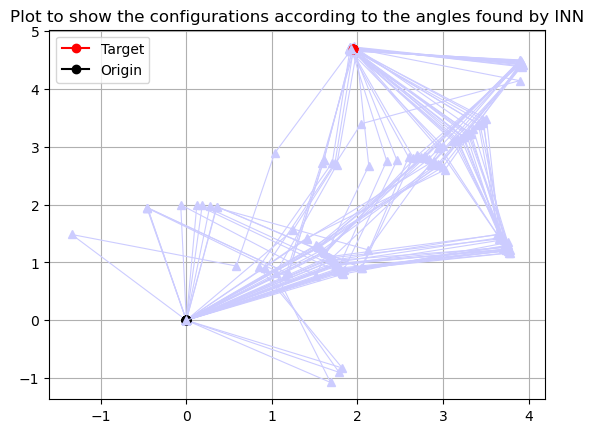

In [34]:

epsilon = 0.05

#Plotting
p_x,p_y=np.zeros((5,count)),np.zeros((5,count))
flag=True

number_config=0

plt.figure()
for i in range(0,reps):
    p_x[:,i],p_y[:,i]=posn(phi=angle_values[i,:])
    pose_found=np.array([[p_x[-1,i],p_y[-1,i]]])
    data_comp=data_ik[ran_int,4:6].reshape((1,2))
    if np.linalg.norm(pose_found-data_ik[ran_int,4:6])<=epsilon:
        # print(angle_values[i,:])
        if flag==True:
            plt.plot(data_ik[ran_int,4],data_ik[ran_int,5],'r',marker='o',label="Target")
            plt.plot(0,0,'k',marker='o',label="Origin")
            plt.plot(p_x[:,i],p_y[:,i],color=lighten_color("b",0.2),lw=0.8,marker='^')
            flag=False
        
        plt.plot(data_ik[ran_int,4],data_ik[ran_int,5],"r",marker='o')
        plt.plot(0,0,'k',marker='o')
        plt.plot(p_x[:,i],p_y[:,i],color=lighten_color("b",0.2),lw=0.8,marker='^')

        number_config+=1
print(data_ik[ran_int,4:6])
print(number_config)   
plt.legend()
plt.grid()
plt.title("Plot to show the configurations according to the angles found by INN")
plt.show()


Setting up trajectory

In [16]:
num_points = 30


circle_radius = 1
centre = np.array([data_ik[ran_int,4]+circle_radius, data_ik[ran_int,5]])

circle_angle = np.array([180,192,204,216,228,240,252,264,276,288,300,312,324,336,348,360,12,24,36,48,60,72,84,96,108,120,132,144,156,168,180])
angle_rad = (np.pi*circle_angle)/180
ang_ini = np.array([1.06494606,0.51521778,-0.40927729,-1.74557841])
x=np.zeros((angle_rad.shape[0],1))
y=np.zeros((angle_rad.shape[0],1))

for i in range(angle_rad.shape[0]):
    x[i,0] = centre[0]+circle_radius*np.cos(angle_rad[i])
    y[i,0] = centre[1]+circle_radius*np.sin(angle_rad[i])

circle_points = np.concatenate((x,y),axis=1)
# print(circle_points)

ini_config=positions(ang_ini[:4])
# print(type(ini_config))
found_angles = np.zeros((num_points,4))                       
for i in range(1,num_points+1):
    # print(circle_points[i,:])
    target=np.array(circle_points[i,:])
    
    found_angles[i-1,:],pose_est = FABRIK_solver(target,ini_config)
    # print(type(found_angles))
    ini_config = positions(found_angles[i-1,:])
print(found_angles.shape)


(30, 4)


Using the configuration found using INN, we set it as the initial configuration to track a given trajectory using the inverse kinematics model

In [17]:
# Forward kinematics for the obtained inverse kinematics for a circular trajectory
def forward_kinematics(x, p = parameters):
    y1 =  p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1]) + p["l"]*np.sin(x[:,2]) + p["l"]*np.sin(x[:,3])
    y2 =  p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1]) + p["l"]*np.cos(x[:,2]) + p["l"]*np.cos(x[:,3])
    return np.array([y1, y2])

def coordinates(x, dim,p=parameters):
    x_c=np.zeros((dim,5))
    y_c=np.zeros((dim,5))

    y_c[:,1] = p["l"]*np.sin(x[:,0])
    y_c[:,2] = p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1])
    y_c[:,3] = p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1]) + p["l"]*np.sin(x[:,2])
    y_c[:,4] = p["l"]*np.sin(x[:,0]) + p["l"]*np.sin(x[:,1]) + p["l"]*np.sin(x[:,2]) + p["l"]*np.sin(x[:,3])
    
    x_c[:,1] = p["l"]*np.cos(x[:,0])
    x_c[:,2] = p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1])
    x_c[:,3] = p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1]) + p["l"]*np.cos(x[:,2])
    x_c[:,4] = p["l"]*np.cos(x[:,0]) + p["l"]*np.cos(x[:,1]) + p["l"]*np.cos(x[:,2]) + p["l"]*np.cos(x[:,3])
    
    return x_c, y_c  # shape of both x_c and y_c is 100000x5
    

Plotting trajectory tracking using INN to find initial config and then using inverse kinematics

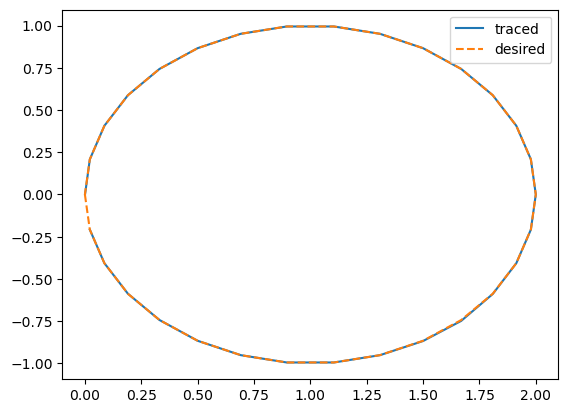

In [18]:
dim=found_angles.shape[0]
joint_coordinates_obt_x,joint_coordinates_obt_y=coordinates(found_angles,dim)
plt.figure()
plt.plot(joint_coordinates_obt_x[:,-1],joint_coordinates_obt_y[:,-1])
plt.plot(x,y,'--')
plt.legend(['traced','desired'])
